# How to Improve Class Imbalance using Class Weights in Machine Learning

https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

https://www.kaggle.com/swatis1/stroke-prediction

## Introduction

https://www.jeremyjordan.me/imbalanced-data/

[imbalance in trees+good pics for other slides](https://amueller.github.io/aml/05-advanced-topics/11-imbalanced-datasets.html)

A classification problem in machine learning is where we have given some input (independent variables), and we have to predict a discrete target. It is highly possible that the distribution of discrete values will be very different. Due to this difference in each class, the algorithms tend to get biased towards the majority values present and don’t perform well on the minority values.

This difference in class frequencies affects the overall predictability of the model.

Getting good accuracy on these problems is not very difficult, but it is not always about getting a good score. We need to check whether the performance of these models makes any business sense or have any value. That is why it is essential to understand your problem statement and data so that you could use the right metric and optimize it using suitable methods.

## What is Class Imbalance?

Class imbalance is a problem that occurs in machine learning classification problems. It merely tells that the target class’s frequency is highly imbalanced, i.e., the occurrence of one of the classes is very high compared to the other classes present. In other words, there is a bias or skewness towards the majority class present in the target. Suppose we consider a binary classification where the majority target class has 10000 rows, and the minority target class has only 100 rows. In that case, the ratio is 100:1, i.e., for every 100 majority class, there is only one minority class present. This problem is what we refer to as class imbalance. Some of the general areas where we can find such data are fraud detection, churn prediction, medical diagnosis, e-mail classification, etc.

We will be working on a dataset from the medical domain to understand class imbalance properly. Here, we have to predict whether a person will have a heart stroke or not based on the given attributes(independent variables). To skip the cleaning and the preprocessing of the data, we are using the cleaned version of the data.

In the below image, you can see the distribution of our target variable.

In [71]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [114]:
data = pd.read_csv("./dataset/train_strokes.csv")

/home/mgh/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Percentage of patients will/will not have heart stroke')

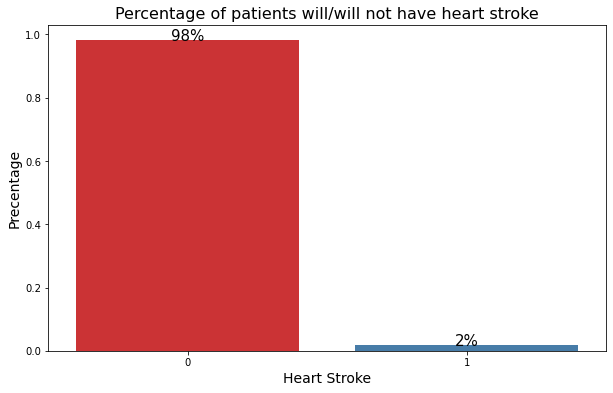

In [115]:
#Ploting barplot for target 
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
g = sns.barplot(data['stroke'], data['stroke'], palette='Set1', estimator=lambda x: len(x) / len(data) )

#Anotating the graph
for p in g.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        g.text(x+width/2, 
               y+height, 
               '{:.0%}'.format(height), 
               horizontalalignment='center',fontsize=15)

#Setting the labels
plt.xlabel('Heart Stroke', fontsize=14)
plt.ylabel('Precentage', fontsize=14)
plt.title('Percentage of patients will/will not have heart stroke', fontsize=16)

Here,

* 0: signifies that the patient didn’t have a heart stroke.

* 1: signifies that the patient had a heart stroke.

From the distribution, we can see that there are only 2% of patients who had a heart stroke. So, this is a classic class imbalance problem.

In [116]:
data['stroke'].value_counts()

0    42617
1      783
Name: stroke, dtype: int64

## Why is it essential to deal with class imbalance?

So far, we got the intuition about class imbalance. But why is it necessary to overcome this, and what problems does it create while modeling with such data?

Most machine learning algorithms assume that the data is evenly distributed within classes. In the case of class imbalance problems, the extensive issue is that the algorithm will be more biased towards predicting the majority class (no heart stroke in our case). The algorithm will not have enough data to learn the patterns present in the minority class (heart stroke).

Let’s take a real-life example to understand this better.

Consider you have shifted from your hometown to a new city and you been living here for the past month. When it comes to your hometown, you will be very familiar with all the locations like your home, routes, essential shops, tourist spots, etc. because you had spent your whole childhood there. But when it comes to the new city, you would not have many ideas about where each location exactly is, and the chances of taking the wrong routes and getting lost will be very high. Here, your hometown is your majority class, and the new city is the minority class.

Similarly, this happens in class imbalance. The model has adequate information about the majority class but insufficient information about your minority class. That is why there will be high misclassification errors for the minority class.

**Note:** *To check the performance of the model, we will be using the f1 score as the metric, not accuracy.*

The reason is if we create a dumb model that predicts every new training data as 0 (no heart stroke) even then we will get very high accuracy because the model is biased towards the majority class. Here, the model is heavily accurate but not at all serving any value to our problem statement. That is why we will be using f1 score as the evaluation metric. F1 score is nothing but the harmonic mean of precision and recall. However, the evaluation metric is chosen based on the business problem and what type of error we want to reduce. But, the f1 score is the go-to metric when it comes to class imbalance problems.

Here’s the formula for f1-score:

$$
\text{f1-score} = \frac{2(\text{precision*recall})}{(\text{precision+recall})}
$$

Let’s confirm this by training a model based on the model of the target variable on our heart stroke data and check what scores we get:

In [117]:
#performing label encoding for the dataset
from sklearn import preprocessing 

encoder = preprocessing.LabelEncoder()

for col in data.columns:
    if isinstance(data[col][1], str):
            data[col] = encoder.fit_transform(data[col])

In [118]:
data.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,1,3.0,0,0,0,4,0,95.12,18.0,3,0
1,30468,1,58.0,1,0,1,2,1,87.96,39.2,1,0
2,16523,0,8.0,0,0,0,2,1,110.89,17.6,3,0
3,56543,0,70.0,0,0,1,2,0,69.04,35.9,0,0
4,46136,1,14.0,0,0,0,1,0,161.28,19.1,3,0
5,32257,0,47.0,0,0,1,2,1,210.95,50.1,3,0
6,52800,0,52.0,0,0,1,2,1,77.59,17.7,0,0
7,41413,0,75.0,0,1,1,3,0,243.53,27.0,1,0
8,15266,0,32.0,0,0,1,2,0,77.67,32.3,2,0
9,28674,0,74.0,1,0,1,3,1,205.84,54.6,1,0


In [119]:
is_NaN = data.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = data[row_has_NaN]
rows_with_NaN

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
81,51676,0,61.0,0,0,1,3,0,202.21,NaN,1,1
95,31091,1,34.0,0,1,1,2,1,106.23,NaN,0,0
113,54312,0,76.0,1,0,1,3,1,209.58,NaN,1,0
186,11999,0,63.0,0,0,1,0,0,79.92,NaN,2,0
231,22470,1,61.0,0,0,1,0,1,184.15,NaN,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43317,2558,0,62.0,0,1,1,0,1,72.29,NaN,1,0
43339,10463,0,76.0,0,0,0,2,0,100.55,NaN,1,1
43351,7580,0,58.0,1,0,1,2,1,99.29,NaN,3,0
43371,18119,0,78.0,0,0,1,2,1,182.45,NaN,0,0


In [120]:
for col in data.columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

In [121]:
is_NaN = data.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = data[row_has_NaN]
rows_with_NaN

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [122]:
#dropping the output label
X= data.drop('stroke', axis=1)
X.shape

(43400, 11)

In [123]:
#standardizing the dataset with Standard Scaler
from sklearn.preprocessing import StandardScaler 
  
scalar = StandardScaler() 
  
for col in X.columns:
    X[[col]] = scalar.fit_transform(X[[col]])

In [124]:
X.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,-0.268469,1.201081,-1.741517,-0.321296,-0.223342,-1.344203,1.659945,-1.002584,-0.217176,-1.384161,1.286407
1,-0.278007,1.201081,0.700823,3.112398,-0.223342,0.743935,-0.169637,0.997423,-0.383258,1.390824,-0.539686
2,-0.939789,-0.830841,-1.519486,-0.321296,-0.223342,-1.344203,-0.169637,0.997423,0.148621,-1.436520,1.286407
3,0.959423,-0.830841,1.233697,-0.321296,-0.223342,0.743935,-0.169637,-1.002584,-0.822123,0.958869,-1.452733
4,0.465542,1.201081,-1.253049,-0.321296,-0.223342,-1.344203,-1.084428,-1.002584,1.317458,-1.240176,1.286407
5,-0.193108,-0.830841,0.212355,-0.321296,-0.223342,0.743935,-0.169637,0.997423,2.469593,2.817585,1.286407
6,0.781793,-0.830841,0.434386,-0.321296,-0.223342,0.743935,-0.169637,0.997423,-0.623799,-1.423430,-1.452733
7,0.241405,-0.830841,1.455728,-0.321296,4.477446,0.743935,0.745154,-1.002584,3.225312,-0.206102,-0.539686
8,-0.999442,-0.830841,-0.453738,-0.321296,-0.223342,0.743935,-0.169637,-1.002584,-0.621943,0.487645,0.373360
9,-0.363145,-0.830841,1.411322,3.112398,-0.223342,0.743935,0.745154,0.997423,2.351062,3.406615,-0.539686


In [125]:
y= data['stroke']
y.shape

(43400,)

In [126]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3, random_state = 1000)

In [127]:
log= LogisticRegression()

In [128]:
log.fit(X_train,y_train)

LogisticRegression()

## Class weights in Logistic Regression

We can modify every machine learning algorithm by adding different class weights to the cost function of the algorithm, but here we will specifically focus on logistic regression.

For the logistic regression, we use log loss as the cost function. We don’t use the mean squared error as the cost function for the logistic regression because instead of fitting a straight line, we use the sigmoid curve as the prediction function. Squaring the sigmoid function will result in a non-convex curve due to which the cost function will have a lot of local minima and converging to the global minima using gradient descent is extremely difficult. But log loss forms a convex function, and we only have one minimum to converge.

The formula for log loss:

$$
log~loss = \frac{1}{N}\sum_{i=1}^{N}\Big{(}-(y_i\log(\hat{y}_i)+(1-y_i)\log(1-\hat{y}_i)) \Big{)}
$$


Here,

- N is the number of values
- yi is the actual value of the target class
- yi is the predicted probability of the target class

Let’s form a pseudo table that has actual predictions, predicted probabilities, and calculated cost using the log loss formula:

|Actual Value|Predicted Prob.(class 1)|Penalty Cost|
|:-:|:-:|:-:|
|0|0.32|0.385|
|0|0.18|0.198|
|0|0.28|0.328|
|0|0.12|0.127|
|0|0.08|0.083|
|**1**|**0.44**|**0.82**|
|0|0.24|0.274|
|0|0.01|0.01|
|0|0.22|0.248|
|0|0.16|0.174|

In this table, we have ten observations with nine observations from class 0 and 1 from class 1. In the next column, we have the predicted probabilities for each observation. And finally, using the log loss formula, we have the cost penalty.

After adding the weights to the cost function, the modified log loss function is:

$$
log~loss = \frac{1}{N}\sum_{i=1}^{N}\Big{(}-(w_0y_i\log(\hat{y}_i)+w_1(1-y_i)\log(1-\hat{y}_i)) \Big{)}
$$

Here,

- w0 is the class weight for class 0
- w1 is the class weight for class 1

Now, we will add the weights and see what difference will it make to the cost penalty.

For the values of the weights, we will be using the class_weights=’balanced’ formula.

w0= 10/(2*1) = 5

w1= 10/(2*9) = 0.55

Calculating the cost for the first value in the table:

Cost = -(5(0*log(0.32) + 0.55(1-0)*log(1-0.32))

= -(0 + 0.55*log(.68))

= -(0.55*(-0.385))

= 0.211

Similarly, we can calculate the weighted cost for each observation, and the updated table is:

|Actual Value|Predicted Prob.(class 1)|Penalty Cost|
|:-:|:-:|:-:|
|0|0.32|0.211|
|0|0.18|0.109|
|0|0.28|0.18|
|0|0.12|0.069|
|0|0.08|0.045|
|**1**|**0.48**|**4.104**|
|0|0.24|0.15|
|0|0.01|0.005|
|0|0.22|0.136|
|0|0.16|0.095|

Through the table, we can confirm the small weight applied to the cost function for the majority class that results in a smaller error value, and in turn, less update to the model coefficients. A more considerable weight value applied to the cost function for the minority class that results in a larger error calculation, and in turn, more updates to the model coefficients. This way, we can shift the bias of the model so that it could also reduce the errors of the minority class.

 

**Conclusion:**

- Small weights result in a small penalty and a small update to the model coefficients
- Large weights result in a large penalty and a large update to the model coefficients

In [129]:
#the accuracy has dropped
log.score(X_train, y_train)

0.9822580645161291

In [69]:
#predicting the output with Logistic
pred_train= log.predict(X_train)

In [70]:
#Training the model using mode of target
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
pred_test= log.predict(X_test)

#Printing f1 and accuracy scores    
print('The accuracy for mode model is:', accuracy_score(y_test, pred_test))
print('The f1 score for the mode model is:',f1_score(y_test, pred_test))

#Ploting the cunfusion matrix
confusion_matrix(y_test, pred_test)

The accuracy for mode model is: 0.9812596006144393
The f1 score for the mode model is: 0.0


array([[12776,     0],
       [  244,     0]])

The accuracy for the mode model is: **0.9819508448540707**

The f1 score for the mode model is: **0.0**

Here, the accuracy of the mode model on the testing data is 0.98 which is an excellent score. But on the other hand, the f1 score is zero which indicates that the model is performing poorly on the minority class. We can confirm this by looking at the confusion matrix.

The mode model is predicting every patient as 0 (no heart stroke). According to this model, no matter what the symptoms a patient has, he/she will never have a heart stroke. Does using this model makes any sense?

Now that we got the gist of what is class imbalance and how it plagues our model performance, we will shift our focus to what class weights are and how class weights can help in improving the model performance.

## What are the class weights?

Most machine learning algorithms are not very useful with biased class data. But, we can modify the current training algorithm to take into account the skewed distribution of the classes. This can be achieved by giving different weights to both the majority and minority classes. The difference in weights will influence the classification of the classes during the training phase. The whole purpose is to penalize the misclassification made by the minority class by setting a higher class weight and at the same time reducing weight for the majority class.

To make this a bit clear, we will be reviving the city example we considered earlier.

Please think of it this way that the last month you have spent in the new city, instead of going out when it is needed, you spent the whole month exploring the city. You spent more time understanding the city routes and places the entire month. Giving more time to research will help you to understand the new city better, and the chances of getting lost will reduce. And this is precisely how class weights work. During the training, we give more weightage to the minority class in the cost function of the algorithm so that it could provide a higher penalty to the minority class and the algorithm could focus on reducing the errors for the minority class.

**Note:** *There is a threshold to which you should increase and decrease the class weights for the minority and majority class respectively. If you give very high-class weights to the minority class, chances are the algorithm will get biased towards the minority class, and it will increase the errors in the majority class.*

Most of the sklearn classifier modeling libraries and even some boosting based libraries like LightGBM and catboost have an in-built parameter “class_weight” which helps us optimize the scoring for the minority class just the way we have learned so far.

By default, the value of class_weight=None, i.e. both the classes have been given equal weights. Other than that, we can either give it as ‘balanced’ or we can pass a dictionary that contains manual weights for both the classes.

When the class_weights = ‘balanced’, the model automatically assigns the class weights inversely proportional to their respective frequencies.

To be more precise, the formula to calculate this is:

$$
wj=\frac{n\_samples}{(n\_classes * n\_samplesj)}
$$

Here,

- wj is the weight for each class(j signifies the class)
- n_samples is the total number of samples or rows in the dataset
- n_classes is the total number of unique classes in the target
- n_samplesj is the total number of rows of the respective class

For our heart stroke example:

n_samples=  43400,  n_classes= 2(0&1), n_sample0= 42617, n_samples1= 783

Weights for class 0:

w0=  43400/(2*42617) = 0.509

Weights for class 1:

w1= 43400/(2*783) = 27.713

I hope this makes things more clear that how class_weight = ‘balanced’ helps us to in giving higher weights to the minority class and lower weights to the majority class.

Although passing value as ‘balanced’ gives good results in most cases but sometimes for extreme class imbalance, we can try giving weights manually. Later we will see how we can find the optimal value for the class weights in Python.